In [7]:
# Imports

# Default libs:
import csv
import os
import numpy as np
import pandas as pd
import random
import sys
import warnings
import datetime
import requests
import re
import collections
import io
import emoji


# Dummy, SVM and metrics: 
import sklearn.metrics
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline, FeatureUnion

# Visualization:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm
import seaborn as sebrn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as atlas
sb = sns

## Loading the data

In [8]:
# Loading the training data
from google.colab import files
train = files.upload()

Saving dalc_train.csv to dalc_train.csv


In [9]:
# Loading the dev data
dev = files.upload()

Saving dalc_dev.csv to dalc_dev.csv


In [10]:
# Loading the DALC test data
test_dalc = files.upload()

Saving dalc_test.csv to dalc_test.csv


In [11]:
# Loading the hate test data
test_hate = files.upload()

Saving hate_test.csv to hate_test.csv


## Creating Dataframes

In [12]:
# Create pandas DataFrame
train_df = pd.read_csv(io.BytesIO(train['dalc_train.csv']))
dev_df = pd.read_csv(io.BytesIO(dev['dalc_dev.csv']))
dalc_test_df = pd.read_csv(io.BytesIO(test_dalc['dalc_test.csv']))
hate_test_df = pd.read_csv(io.BytesIO(test_hate['hate_test.csv']))

# Function which replace string labels with numerical labels and returns new dataset with transformed labels
def transform_labels(df):
  new1 = df.replace('INDIVIDUAL', 0)
  new2 = new1.replace('GROUP', 1)
  new3 = new2.replace('OTHER', 2)

  return new3

# Dataframes with numerical labels
train_df = transform_labels(train_df)
dev_df = transform_labels(dev_df)
dalc_test_df = transform_labels(dalc_test_df)
hate_test_df = transform_labels(hate_test_df)

### Dummy Classifier
https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html

In [13]:
# Dummy classifier which use the most frequent class
LABELS = ['INDIVIDUAL', 'GROUP', 'OTHER']
dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(train_df.Text, train_df.Target)
print(dummy.score(dev_df.Text, dev_df.Target), dummy.score(dalc_test_df.Text, dalc_test_df.Target), dummy.score(hate_test_df.Text, hate_test_df.Target), LABELS[np.argmax(dummy.class_prior_, axis=-1)])

# Print reports
print('dev:',classification_report(dev_df.Target, dummy.predict(dev_df.Text)))
print('test dalc:',classification_report(dalc_test_df.Target, dummy.predict(dalc_test_df.Text)))
print('test hate:',classification_report(hate_test_df.Target, dummy.predict(hate_test_df.Text)))

0.5636363636363636 0.5236541598694943 0.6468646864686468 INDIVIDUAL
dev:               precision    recall  f1-score   support

           0       0.56      1.00      0.72        62
           1       0.00      0.00      0.00        33
           2       0.00      0.00      0.00        15

    accuracy                           0.56       110
   macro avg       0.19      0.33      0.24       110
weighted avg       0.32      0.56      0.41       110

test dalc:               precision    recall  f1-score   support

           0       0.52      1.00      0.69       321
           1       0.00      0.00      0.00       215
           2       0.00      0.00      0.00        77

    accuracy                           0.52       613
   macro avg       0.17      0.33      0.23       613
weighted avg       0.27      0.52      0.36       613

test hate:               precision    recall  f1-score   support

           0       0.65      1.00      0.79       196
           1       0.00      0.00 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classificat

## Preprocessing

In [14]:
# Preprocessing function which returns cleaned data
def clean_samples(data):
  new_samples = []
  content = list(data['Text'].values)
  for tweet_message in content:
      tweet_message = re.sub(r'https.*[^ ]', 'URL', tweet_message)
      tweet_message = re.sub(r'http.*[^ ]', 'URL', tweet_message)
      tweet_message = re.sub(r'@([^ ]*)', '@USER', tweet_message)
      tweet_message = emoji.demojize(tweet_message)
      tweet_message = re.sub(r'(:.*?:)', r' \1 ', tweet_message)
      tweet_message = re.sub(' +', ' ', tweet_message)
      tweet_message = tweet_message.lower()
      new_samples.append(tweet_message)

  return new_samples

In [15]:
# Preprocess training data
train_text_list = list(train_df.Text)
train_labels = list(train_df.Target)
preprocessed_train_text = clean_samples(train_df)
preprocessed_train_df = pd.DataFrame(data=preprocessed_train_text, columns=['Text'])
preprocessed_train_df['Target'] = train_labels

# Preprocess dev data
dev_text_list = list(dev_df.Text)
dev_labels = list(dev_df.Target)
preprocessed_dev_text = clean_samples(dev_df)
preprocessed_dev_df = pd.DataFrame(data=preprocessed_dev_text, columns=['Text'])
preprocessed_dev_df['Target'] = dev_labels

# Preprocess dalc test data
test_dalc_text_list = list(dalc_test_df.Text)
dalc_test_labels = list(dalc_test_df.Target)
preprocessed_dalc_test_text = clean_samples(dalc_test_df)
preprocessed_dalc_test_df = pd.DataFrame(data=preprocessed_dalc_test_text, columns=['Text'])
preprocessed_dalc_test_df['Target'] = dalc_test_labels

# Preprocess hate test data
test_hate_text_list = list(hate_test_df.Text)
hate_test_labels = list(hate_test_df.Target)
preprocessed_hate_test_text = clean_samples(hate_test_df)
preprocessed_hate_test_df = pd.DataFrame(data=preprocessed_hate_test_text, columns=['Text'])
preprocessed_hate_test_df['Target'] = hate_test_labels

## SVM with Bag of Words

In [21]:
# Implementing a Linear SVM
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pipeline = Pipeline([
        ('feats', FeatureUnion([
            ('word_ngram', CountVectorizer(ngram_range=(1,1), analyzer='word'))
            #('char_ngram', CountVectorizer(ngram_range=(5,5), analyzer='char')) 
        ])),
        ('clf', LinearSVC(C=0.1))  # classifier
    ])

    model = pipeline.fit(preprocessed_train_text, train_labels)
    predicted_test_labels = model.predict(preprocessed_dev_text)
    accuracy = accuracy_score(dev_labels, predicted_test_labels) 

    print(accuracy)
    print(classification_report(dev_labels, predicted_test_labels))

0.6545454545454545
              precision    recall  f1-score   support

           0       0.77      0.81      0.79        62
           1       0.48      0.61      0.53        33
           2       0.67      0.13      0.22        15

    accuracy                           0.65       110
   macro avg       0.64      0.52      0.51       110
weighted avg       0.67      0.65      0.63       110



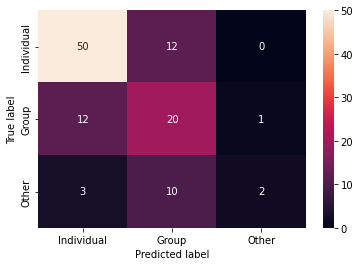

In [22]:
# Print confusion matrix
conf_matrix = (confusion_matrix(dev_labels, predicted_test_labels))

fx = sebrn.heatmap(conf_matrix, annot=True, fmt='g')
fx.set_xlabel('Predicted label')
fx.set_ylabel('True label');

# Labels the boxes
fx.xaxis.set_ticklabels(['Individual','Group','Other'])
fx.yaxis.set_ticklabels(['Individual','Group','Other'])

atlas.show()